# 1. Random Dataset Example

## 1.1 Dataset Information

- **Features:** 2
- **Classes:** 2

## 1.2 Description

This dataset is generated randomly with 2 features. Each feature is represented by a numeric value. There are two classes in the dataset, each representing a distinct category or label.



In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.svm import SVC, LinearSVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV

### 1.3 Generating Synthetic Data:

1. **Center Definition**: 
   - Two centers are defined, `center1` and `center2`, representing the mean values for two classes.

2. **Data Generation**:
   - Synthetic data is generated around these centers using `np.random.normal()` with specified mean (`loc`) and standard deviation (`scale`).

3. **Label Creation**:
   - Labels are created for each class, where `labels1` is set to 0 and `labels2` is set to 1.

4. **Data Concatenation**:
   - Data and labels are concatenated to form two separate datasets, `data1` and `data2`.



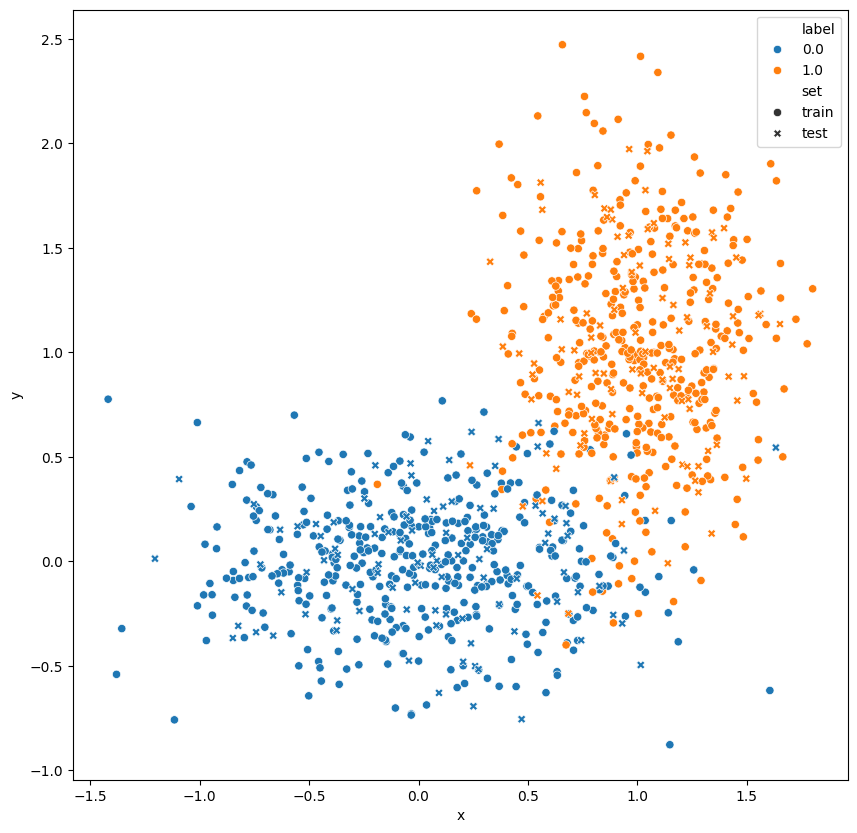

In [2]:
# Generating synthetic data
center1 = np.array([0, 0])
center2 = np.array([1, 1])

data1 = np.random.normal(loc=center1, scale=(0.5, 0.3), size=(500, 2))
data2 = np.random.normal(loc=center2, scale=(0.3, 0.5), size=(500, 2))

labels1 = np.zeros(500)
labels2 = np.ones(500)

data1 = np.concatenate((data1, labels1.reshape(-1, 1)), axis=1)
data2 = np.concatenate((data2, labels2.reshape(-1, 1)), axis=1)

data = np.concatenate((data1, data2), axis=0)

np.random.shuffle(data)

# Splitting the data
train, test = train_test_split(data, test_size=0.2)

# Creating dataframes for visualization
train_df = pd.DataFrame(train, columns=['x', 'y', 'label'])
train_df['set'] = 'train'

test_df = pd.DataFrame(test, columns=['x', 'y', 'label'])
test_df['set'] = 'test'

data_df = pd.concat([train_df, test_df], axis=0)

# Saving the data
np.save('./data/generated_data.npy', data)
np.save('./data/generated_data_train.npy', train)
np.save('./data/generated_data_test.npy', test)
data_df.to_csv('./data/generated_data.csv', index=False)

# Visualizing the dataset
plt.figure(figsize=(10, 10))
sns.scatterplot(x='x', y='y', hue='label', style='set', data=data_df)
plt.show()


### 1.4 Training SVM :

1. **Load the Dataset**:
   - The `np.load()` function is used to load the dataset stored in the file `generated_data.npy` located in the `./data/` directory.
   - The loaded data is assigned to the variable `data`.

2. **Split Data for Cross-Validation**:
   - The `data` array contains both features and labels. The features are stored in the first two columns, and the labels are stored in the third column.
   - The feature matrix `X` is created by selecting all rows of `data` and the first two columns using slicing (`data[:, :2]`).
   - The target vector `y` is created by selecting all rows of `data` and the third column using slicing (`data[:, 2]`).
   - The `train_test_split()` function is used to split the dataset into training and validation sets for cross-validation.
   - The feature matrix `X` and the target vector `y` are split into training and validation sets (`X_train`, `X_val`, `y_train`, `y_val`) with a test size of 20% (`test_size=0.2`).
   - The parameter `random_state=42` ensures reproducibility by fixing the random seed.



In [116]:
data = np.load('./data/generated_data.npy')
X, y = data[:, :2], data[:, 2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


3. **Define Hyperparameter Grid**:
   - A dictionary `param_grid` is defined to specify the hyperparameters to search over during grid search cross-validation.
   - The hyperparameters include 'C' (regularization parameter) and 'gamma' (kernel coefficient) for the Support Vector Machine (SVM) classifier.

4. **Perform Grid Search Cross-Validation**:
   - The `GridSearchCV` function from the `sklearn.model_selection` module is used to perform grid search cross-validation.
   - The SVM classifier is specified with the kernel like (`SVC(kernel='linear')`) or (`SVC(kernel='rbf')`) as the estimator.
   - The `param_grid` dictionary is provided to specify the hyperparameters to tune.
   - Cross-validation with 5 folds (`cv=5`) is used to evaluate the performance of each hyperparameter combination.
   - The scoring metric is set to 'accuracy', indicating that the accuracy of the classifier will be used to evaluate each hyperparameter combination.
   - The grid search is parallelized using all available CPU cores (`n_jobs=-1`).
   - The `fit` method is called to perform the grid search and find the best hyperparameters based on the training data (`X_train` and `y_train`).

4. **Print Best Hyperparameters**:
   - After grid search is completed, the best hyperparameters found are printed using the `best_params_` attribute of the `GridSearchCV` object.

6. **Evaluate Model on Test Set**:
   - The best SVM classifier obtained from grid search (`best_estimator_`) is used to make predictions on the test set (`X_test` and `y_test`).
   - The accuracy of the classifier on the test set is computed using the `score` method and printed.

In [133]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [ 0.1, 0.01, 0.001, 0.0001],
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(SVC(kernel='linear'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters for Linear SVM classifier
print("Best hyperparameters for Linear SVM classifier:",grid_search.best_params_)

# Evaluate the model on the test set
best_svm = grid_search.best_estimator_
test_accuracy = best_svm.score(X_test, y_test)
print("Test set accuracy for Linear SVM classifier:",test_accuracy)

Best hyperparameters for Linear SVM classifier: {'C': 1, 'gamma': 0.1}
Test set accuracy for Linear SVM classifier: 0.945


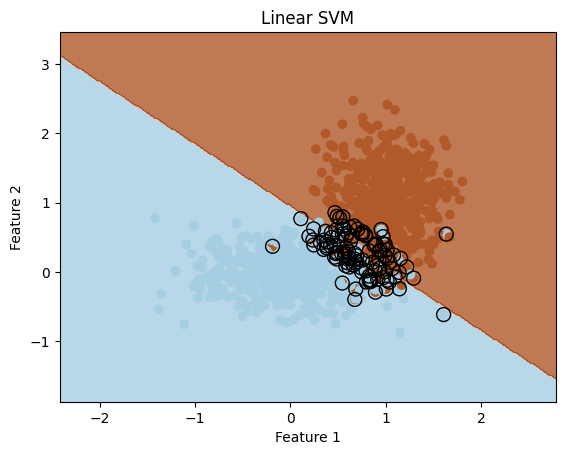

In [136]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

Z = best_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
    
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.scatter(best_svm.support_vectors_[:, 0], best_svm.support_vectors_[:, 1], s=100,
                facecolors='none', edgecolors='k', label='Support Vectors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linear SVM')
plt.show()

In [137]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [ 0.1, 0.01, 0.001, 0.0001],
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters for Linear SVM classifier
print("Best hyperparameters for RBF SVM classifier:",grid_search.best_params_)

# Evaluate the model on the test set
best_svm = grid_search.best_estimator_
test_accuracy = best_svm.score(X_test, y_test)
print("Test set accuracy for RBF SVM classifier:",test_accuracy)

Best hyperparameters for RBF SVM classifier: {'C': 1, 'gamma': 0.01}
Test set accuracy for RBF SVM classifier: 0.95


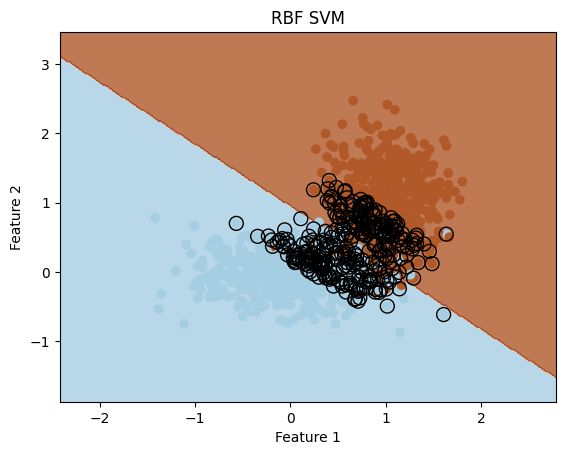

In [138]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

Z = best_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
    
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.scatter(best_svm.support_vectors_[:, 0], best_svm.support_vectors_[:, 1], s=100,
                facecolors='none', edgecolors='k', label='Support Vectors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('RBF SVM')
plt.show()

In [139]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [ 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['poly']
}

svm = SVC()

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters for Linear SVM classifier
print("Best hyperparameters for SVM classifier:",grid_search.best_params_)

# Evaluate the model on the test set
best_svm = grid_search.best_estimator_
test_accuracy = best_svm.score(X_test, y_test)
print("Test set accuracy for SVM classifier:",test_accuracy)

Best hyperparameters for SVM classifier: {'C': 100, 'gamma': 0.1, 'kernel': 'poly'}
Test set accuracy for SVM classifier: 0.95


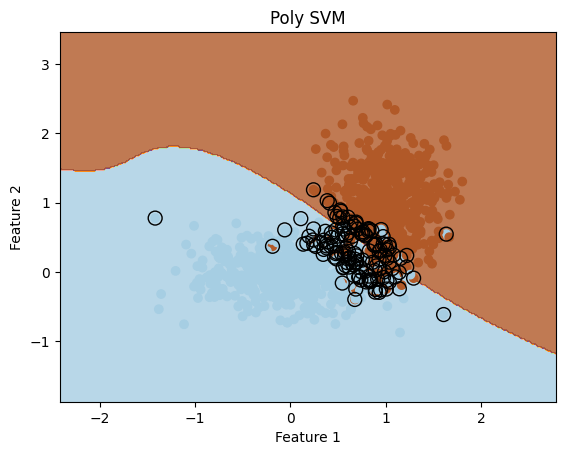

In [140]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

Z = best_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
    
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.scatter(best_svm.support_vectors_[:, 0], best_svm.support_vectors_[:, 1], s=100,
                facecolors='none', edgecolors='k', label='Support Vectors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Poly SVM')
plt.show()

7. **Results**:
   - **Best hyperparameters for Linear SVM classifier:** {'C': 1, 'gamma': 0.1} and **Test set accuracy :** 0.945

   - **Best hyperparameters for RBF SVM classifier:** {'C': 1, 'gamma': 0.01} and **Test set accuracy :** 0.95

   - **Best hyperparameters for Poly SVM classifier:** {'C': 1, 'gamma': 0.01} and  **Test set accuracy for Poly SVM classifier:** 0.95

# 2. 'Real' Dataset

Apply the same procedure as in the previous section to find the best parameters from the pulsar dataset using cross-fold validation.

### 2.1 Description

Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the interstellar medium, and states of matter. Machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis. In particular, classification systems are widely adopted, which treat the candidate datasets as binary classification problems.


### Model Training:

1. **Load Training and Test Data**:
   - Two pandas DataFrames, `train` and `test`, are created by reading CSV files using the `pd.read_csv()` function.
   - The training data is loaded from the file `'./data/pulsar_data_train.csv'`.
   - The test data is loaded from the file `'./data/pulsar_data_test.csv'`.


In [67]:
train = pd.read_csv('./data/pulsar_data_train.csv')
test = pd.read_csv('./data/pulsar_data_test.csv')

2. Columns with Missing Values:

- Excess kurtosis of the integrated profile: 1735 missing values
- Standard deviation of the DM-SNR curve: 1178 missing values
- Skewness of the DM-SNR curve: 625 missing values

3. Impute Missing Values:

`SimpleImputer` - Replace missing values using a descriptive statistic (e.g. mean, median, or most frequent) along each column, or using a constant value.


In [68]:
X_train = train.iloc[:, :-1]  
y_train = train.iloc[:, -1]
X_test = train.iloc[:, :-1]

4. Getting the target labels using iloc
   
- **X_train**: Selects all rows and all columns except the last one from the DataFrame `train`. This separates features from target labels.

- **y_train**: Selects all rows and only the last column from the DataFrame `train`. This extracts the target labels.

- **X_test**: Selects all rows and all columns from the DataFrame `test`. This prepares the test data for evaluation or prediction.


In [83]:
X_train.head(10)

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,26.351318,2.958066,7.197842
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128
5,121.007812,47.176944,0.229708,0.091336,2.036789,26.351318,9.546051,112.131721
6,79.343750,42.402174,1.063413,2.244377,141.641304,26.351318,-0.700809,-1.200653
7,109.406250,55.912521,0.565106,0.056247,2.797659,19.496527,9.443282,97.374578
8,95.007812,40.219805,0.347578,1.153164,2.770067,18.217741,7.851205,70.801938
9,109.156250,47.002234,0.394182,0.190296,4.578595,26.351318,5.702532,36.342493


5. Categorical Features:
- No categorical columns were found in the dataset.


In [112]:
data_types = X_train.dtypes

categorical_columns = data_types[data_types == 'object'].index.tolist()

print("Categorical Features:")
print(categorical_columns)

Categorical Columns:
[]


In [72]:
missing_values = X_train.isnull().sum()
print("Columns with missing values:")
print(missing_values)

Columns with missing values:
Mean of the integrated profile                     0
Standard deviation of the integrated profile       0
Excess kurtosis of the integrated profile       1735
Skewness of the integrated profile                 0
Mean of the DM-SNR curve                           0
Standard deviation of the DM-SNR curve          1178
Excess kurtosis of the DM-SNR curve                0
Skewness of the DM-SNR curve                     625
dtype: int64


In [73]:
missing_values = X_test.isnull().sum()
print("Columns with missing values:")
print(missing_values)

Columns with missing values:
Mean of the integrated profile                     0
Standard deviation of the integrated profile       0
Excess kurtosis of the integrated profile       1735
Skewness of the integrated profile                 0
Mean of the DM-SNR curve                           0
Standard deviation of the DM-SNR curve          1178
Excess kurtosis of the DM-SNR curve                0
Skewness of the DM-SNR curve                     625
dtype: int64


In [76]:
train_missing_values = X_train.columns[X_train.isnull().any()].tolist()
print("Columns with Missing Values in training set: ",train_missing_values)

test_missing_values = X_test.columns[X_test.isnull().any()].tolist()
print("Columns with Missing Values in training set: ",test_missing_values)

Columns with Missing Values in training set:  [' Excess kurtosis of the integrated profile', ' Standard deviation of the DM-SNR curve', ' Skewness of the DM-SNR curve']
Columns with Missing Values in training set:  [' Excess kurtosis of the integrated profile', ' Standard deviation of the DM-SNR curve', ' Skewness of the DM-SNR curve']


In [79]:
imputer = SimpleImputer(strategy='mean')

X_train.loc[:, train_missing_values] = imputer.fit_transform(X_train.loc[:, train_missing_values])

X_test.loc[:, test_missing_values] = imputer.transform(X_test.loc[:, test_missing_values])

In [81]:
missing_values = X_train.isnull().sum()
print("Columns with missing values in training set:")
print(missing_values)

Columns with missing values in training set:
Mean of the integrated profile                  0
Standard deviation of the integrated profile    0
Excess kurtosis of the integrated profile       0
Skewness of the integrated profile              0
Mean of the DM-SNR curve                        0
Standard deviation of the DM-SNR curve          0
Excess kurtosis of the DM-SNR curve             0
Skewness of the DM-SNR curve                    0
dtype: int64


In [82]:
missing_values = X_test.isnull().sum()
print("Columns with missing values in test set:")
print(missing_values)

Columns with missing values in test set:
Mean of the integrated profile                  0
Standard deviation of the integrated profile    0
Excess kurtosis of the integrated profile       0
Skewness of the integrated profile              0
Mean of the DM-SNR curve                        0
Standard deviation of the DM-SNR curve          0
Excess kurtosis of the DM-SNR curve             0
Skewness of the DM-SNR curve                    0
dtype: int64


6. Normalizing numerical features:

- **scaler = StandardScaler()**: Initializes a StandardScaler object. StandardScaler is a preprocessing technique used to standardize features by removing the mean and scaling to unit variance.

- **X_train = scaler.fit_transform(X_train)**: Fits the scaler to the training data.


In [84]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

7. GridSearch:

- **param_grid**: Defines a grid of hyperparameters to search over during grid search. The grid includes different values of 'C' (regularization parameter), 'gamma' (kernel coefficient), and 'kernel' (type of kernel function).

- **svm = SVC()**: Initializes a Support Vector Classifier (SVC) instance. This will be used as the base estimator for grid search.

- **Grid Search**: Performs a grid search with 5-fold cross-validation (`cv=5`) to find the best combination of hyperparameters from the provided grid. The scoring metric used is accuracy (`scoring='accuracy'`). Grid search is parallelized (`n_jobs=-1`) to utilize multiple CPU cores.

- **Fit Grid Search**: Fits the grid search object to the training data (`X_train`, `y_train`). This process involves training multiple SVM models with different hyperparameter combinations and selecting the best-performing one based on cross-validation scores.

- **Best Hyperparameters**: Prints the best hyperparameters found by grid search for the SVM classifier.

- **Evaluate on Test Set**: Retrieves the best estimator from grid search and evaluates its performance on the training set. The training accuracy is printed to assess how well the model fits the training data.


In [85]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [ 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['poly','rbf','linear']
}

svm = SVC()

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters for Linear SVM classifier
print("Best hyperparameters for SVM classifier:",grid_search.best_params_)

# Evaluate the model on the test set
best_svm = grid_search.best_estimator_
train_accuracy = best_svm.score(X_train, y_train)
print("Train set accuracy for SVM classifier:",train_accuracy)

Best hyperparameters for SVM classifier: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Train set accuracy for SVM classifier: 0.9807630906768838


8. Results:

- **Best hyperparameters for SVM classifier:** {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
- **Train set accuracy for SVM classifier:** 0.9807630906768838

- **F1 score:** 0.8881670533642692


In [100]:
y_train_pred = best_svm.predict(X_train)
f1 = f1_score(y_train, y_train_pred)
print("F1 score:", f1)

F1 score: 0.8881670533642692


In [86]:
y_test_pred = best_svm.predict(X_test)

In [89]:
y_test_pred = pd.DataFrame({'target_classes': y_test_pred})
y_test_pred.to_csv('y_pred_test.csv', index=False)

In [114]:
print(y_test_pred)

       target_classes
0                 0.0
1                 0.0
2                 0.0
3                 0.0
4                 0.0
...               ...
12523             0.0
12524             0.0
12525             0.0
12526             0.0
12527             0.0

[12528 rows x 1 columns]
